In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)
import time

from pbdlib import plot_gmm

from scipy.special import digamma
from scipy.special import logsumexp

from scipy.stats import multivariate_normal as mvn
from scipy.stats import t


from scipy.special import loggamma

from sklearn.metrics import mean_squared_error

from IPython.display import clear_output

In [4]:
from math import *

def t_logpdf(x,df,mu,Sigma):
    '''
    Multivariate t-student density:
    output:
        the density of the given element
    input:
        x = parameter (d dimensional numpy array or scalar)
        mu = mean (d dimensional numpy array or scalar)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom
        d: dimension
    '''
    d = x.shape[0]
    Num = loggamma(1. * (d+df)/2)
    Denom =  loggamma(1.*df/2) + 0.5*d*np.log(df*pi)   + 0.5*np.log(np.linalg.det(Sigma)) + \
            (0.5*(d+df))*np.log(1 + (1./df)*np.dot(np.dot((x - mu),np.linalg.inv(Sigma)), (x - mu)))
    d = Num - Denom  
    return d

In [5]:
def log_normalize(x):
    return x - logsumexp(x)

In [6]:
def filter_gaussian(means_, covariances_, weights_, threshold = 0.01):
    means = [] 
    covs = []
    for i,w in enumerate(weights_):
        if w > threshold:
            means.append(means_[i])
            covs.append(covariances_[i])
    
    means = np.array(means)
    covs = np.array(covs)
    return means,covs

### Define class for GMM and GMR

In [7]:
from sklearn.cluster import KMeans
class GMM():
    def __init__(self, n_comp = 10, D = 1, K = 2, weight_concentration = 0.1):
        self.n_comp = n_comp
        self.D = D
        self.K = K

        #pi params
        self.alpha0 = np.ones(K)*weight_concentration
        self.alpha = np.copy(self.alpha0)

        #mu and sigma params
        self.betha0 = 0.0001
        self.betha = np.ones(self.K)
        self.mu0 = np.zeros(self.D)
        self.v0 = self.D
        self.W0 = np.eye(self.D)/(self.v0)
        #
        self.W = [np.eye(self.D) for i in range(self.K)]
        self.v = np.ones(self.K)*self.D
        
        self.reg_covar = 1e-06
        
    def fit(self,x, num_iter = 10,restart=True):
        self.x = x
        cov = np.cov(x.T)
        #self.W0 = np.linalg.inv(cov)/self.v0
        self.N = self.x.shape[0]
        if restart:
            kMM = KMeans(n_clusters=self.K).fit(x)
            self.mu = kMM.cluster_centers_
            self.mu = x[np.random.choice(len(x),size = self.K)]
        for i in range(num_iter):
            print 'Iteration ' + str(i)
            self.expectation()
            self.maximization()
            
        self.sigma = []
        for k in range(self.K):
            sigma = np.linalg.inv(self.v[k]*self.W[k])
            self.sigma.append(sigma)

        self.weights = self.alpha/np.sum(self.alpha)


    def expectation(self):
        self.ln_ro = np.zeros([self.N,self.K])
        self.ro = np.zeros([self.N,self.K])

        print 'Calculating ro'
        tic = time.time()
        for k in range(self.K):
            E_s = self.D*np.log(2) + np.log(np.linalg.det(self.W[k])) + np.sum([digamma((self.v[k] + 1 - i)/2.) \
                                                                           for i in range(self.D)])
            E_pi = digamma(self.alpha[k]) - digamma(np.sum(self.alpha))
            E_2 = self.D*np.log(2*np.pi)
            for n in range(self.N):
                E_ms = self.D/self.betha[k] + self.v[k]*np.dot(self.x[n] - self.mu[k], np.dot(self.W[k], \
                                                                                self.x[n] - self.mu[k]))
                self.ln_ro[n,k] = E_pi + 0.5*E_s - 0.5*E_2 - 0.5*E_ms

        for n in range(self.N):        
            self.ln_ro[n,:] = log_normalize(self.ln_ro[n,:])
            self.ro[n,:] = np.exp(self.ln_ro[n,:])
        toc = time.time()
        print toc-tic


        self.Nks = np.array([1e-12 + np.sum(self.ro[:,k]) for k in range(self.K)])

        self.xks = np.dot(self.ro.T, self.x)
        for k in range(self.K):
            self.xks[k,:] /= self.Nks[k]


        print 'Calculating Sk' 
        self.Sks = []
        for k in range(self.K):
            Sk = np.zeros([self.D,self.D])
            for n in range(self.N):
                Sk += self.ro[n,k]*np.outer(self.x[n]-self.xks[k], self.x[n]-self.xks[k])
            Sk /= self.Nks[k]
            self.Sks.append(Sk)

        toc = time.time()
        print toc-tic

             
    def maximization(self):
        self.alpha = self.alpha0 + self.Nks
        self.betha = self.betha0 + self.Nks

        for k in range(self.K):
            self.mu[k] = (self.betha0*self.mu0 + self.Nks[k]*self.xks[k])/self.betha[k]
            Wk_inv = np.linalg.inv(self.W0 + self.reg_covar*np.eye(self.D)) + self.Nks[k]*self.Sks[k] + np.outer(self.xks[k]-self.mu0, \
                                    self.xks[k]-self.mu0)*self.betha0*self.Nks[k]/(self.betha0+self.Nks[k])
            self.W[k] = np.linalg.inv(Wk_inv+ self.reg_covar*np.eye(self.D))
            self.v[k] = self.v0 + self.Nks[k]
            
    def plot(self):
        fig,ax = plt.subplots()
        plot_gaussian(self.mu, self.sigma, ax, self.weights )


In [8]:
class BGMR():
    def __init__(self, GMM, n_in, n_out):
        self.GMM = GMM
        self.n_in = n_in
        self.n_out = n_out
        #segment the gaussian components
        self.mu_x = []
        self.mu_y = []
        self.sigma_xx = []
        self.sigma_yy = []
        self.sigma_xy = []

        
        for k in range(self.GMM.K):
            self.mu_x.append(self.GMM.mu[k][0:self.n_in])        
            self.mu_y.append(self.GMM.mu[k][self.n_in:])        
            self.sigma_xx.append(self.GMM.sigma[k][0:self.n_in, 0:self.n_in])        
            self.sigma_yy.append(self.GMM.sigma[k][self.n_in:, self.n_in:])        
            self.sigma_xy.append(self.GMM.sigma[k][0:self.n_in, self.n_in:])
            
        self.mu_x = np.array(self.mu_x)
        self.mu_y = np.array(self.mu_y)
        self.sigma_xx = np.array(self.sigma_xx)
        self.sigma_yy = np.array(self.sigma_yy)
        self.sigma_xy = np.array(self.sigma_xy)
        
        self.vy_x = self.GMM.v + self.n_in
        
        
    def predict(self,x):
        h = []
        mu = []        
        sigma = []

        for k in range(self.GMM.K):
            h.append(np.log(self.GMM.weights[k])+ t_logpdf(x, self.GMM.v[k], self.mu_x[k],self.sigma_xx[k]))
            mu.append(self.mu_y[k] + np.dot(self.sigma_xy[k].T, \
                                            np.dot(np.linalg.inv(self.sigma_xx[k]), x - self.mu_x[k])))
            sigma.append( (self.GMM.v[k] + np.dot(x-self.mu_x[k], np.dot(np.linalg.inv(self.sigma_xx[k]), x-self.mu_x[k]))) \
            *(self.sigma_yy[k]- np.dot(self.sigma_xy[k].T, np.dot(np.linalg.inv(self.sigma_xx[k]), self.sigma_xy[k]))) \
            / self.vy_x[k])
              
        h = np.array(h)
        h = np.exp(log_normalize(h))
        #h = h/np.sum(h)
        mu = np.array(mu)
        #print h,mu
        #print h.shape,mu.shape
        sigma_one = np.zeros([self.n_out, self.n_out])
        mu_one = np.zeros(self.n_out)
        for k in range(self.GMM.K):
            sigma_one += h[k]*(sigma[k] + np.outer(mu[k],mu[k]))
            mu_one += h[k]*mu[k]
            
        sigma_one -= np.outer(mu_one, mu_one)
        return mu_one, sigma_one

In [9]:
class GMR():
    def __init__(self, GMM, n_in, n_out):
        self.GMM = GMM
        self.n_in = n_in
        self.n_out = n_out
        #segment the gaussian components
        self.mu_x = []
        self.mu_y = []
        self.sigma_xx = []
        self.sigma_yy = []
        self.sigma_xy = []
        for k in range(self.GMM.K):
            self.mu_x.append(self.GMM.mu[k][0:self.n_in])        
            self.mu_y.append(self.GMM.mu[k][self.n_in:])        
            self.sigma_xx.append(self.GMM.sigma[k][0:self.n_in, 0:self.n_in])        
            self.sigma_yy.append(self.GMM.sigma[k][self.n_in:, self.n_in:])        
            self.sigma_xy.append(self.GMM.sigma[k][0:self.n_in, self.n_in:])
            
        self.mu_x = np.array(self.mu_x)
        self.mu_y = np.array(self.mu_y)
        self.sigma_xx = np.array(self.sigma_xx)
        self.sigma_yy = np.array(self.sigma_yy)
        self.sigma_xy = np.array(self.sigma_xy)
        
    def predict(self,x):
        h = []
        mu = []        
        sigma = []

        for k in range(self.GMM.K):
            h.append(self.GMM.weights[k]*mvn(mean = self.mu_x[k], cov = self.sigma_xx[k]).pdf(x))
            mu.append(self.mu_y[k] + np.dot(self.sigma_xy[k].T, \
                                            np.dot(np.linalg.inv(self.sigma_xx[k]), x - self.mu_x[k])))
            sigma.append(self.sigma_yy[k]- np.dot(self.sigma_xy[k].T, np.dot(np.linalg.inv(self.sigma_xx[k]), self.sigma_xy[k])))
        
        h = np.array(h)
        h = h/np.sum(h)
        mu = np.array(mu)
        
        sigma_one = np.zeros([self.n_out, self.n_out])
        mu_one = np.zeros(self.n_out)
        for k in range(self.GMM.K):
            sigma_one += h[k]*(sigma[k] + np.outer(mu[k],mu[k]))
            mu_one += h[k]*mu[k]
            
        sigma_one -= np.outer(mu_one, mu_one)
        return mu_one, sigma_one

###  Try GMM with Data

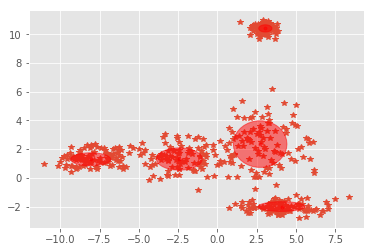

In [279]:
import numpy as np
import matplotlib.pyplot as plt
D = 2
K_true = 5
N = 500
is_plot = True

mus_true = []
sigmas_true = []
samples = []
for k in range(K_true):
    mu = 5*np.random.normal(size=D)
    sigma = 3*np.diag(np.random.rand(D))
    sample = np.random.multivariate_normal(mu, cov = sigma, size = N/K_true)
    mus_true.append(mu)
    sigmas_true.append(sigma)
    samples.append(sample)
    
x = np.vstack(samples)
mus_true = np.array(mus_true)
sigmas_true = np.array(sigmas_true)

if is_plot:
    fig,ax = plt.subplots()
    plot_gmm(mus_true,sigmas_true)#,ax)
    plt.plot(x[:,0],x[:,1],'*',zorder = 1)

In [280]:
gmm = GMM(D = 2, K = 10, weight_concentration=0.01)
gmm.fit(x,num_iter = 50)

Iteration 0
Calculating ro
0.0270590782166
Calculating Sk
0.0572600364685
Iteration 1
Calculating ro
0.0263319015503
Calculating Sk
0.0607988834381
Iteration 2
Calculating ro
0.0263519287109
Calculating Sk
0.0603160858154
Iteration 3
Calculating ro
0.0270049571991
Calculating Sk
0.0640227794647
Iteration 4
Calculating ro
0.0263938903809
Calculating Sk
0.0596258640289
Iteration 5
Calculating ro
0.0260009765625
Calculating Sk
0.0596079826355
Iteration 6
Calculating ro
0.0259609222412
Calculating Sk
0.0594718456268
Iteration 7
Calculating ro
0.0295271873474
Calculating Sk
0.0630860328674
Iteration 8
Calculating ro
0.026379108429
Calculating Sk
0.059522151947
Iteration 9
Calculating ro
0.0262651443481
Calculating Sk
0.0597541332245
Iteration 10
Calculating ro
0.028354883194
Calculating Sk
0.0630087852478
Iteration 11
Calculating ro
0.0264301300049
Calculating Sk
0.0583229064941
Iteration 12
Calculating ro
0.0260541439056
Calculating Sk
0.0593950748444
Iteration 13
Calculating ro
0.02625203

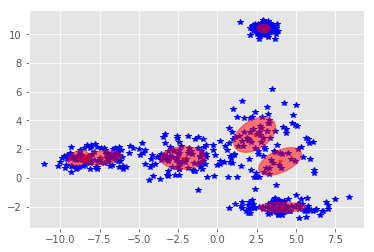

In [281]:
fig,ax = plt.subplots()
means, covs = filter_gaussian(gmm.mu, gmm.sigma, gmm.weights,threshold=0.05)
plot_gmm(means,covs)
plt.plot(x[:,0], x[:,1], '*b',zorder=1)
plt.show()

### Try GMR on Data 

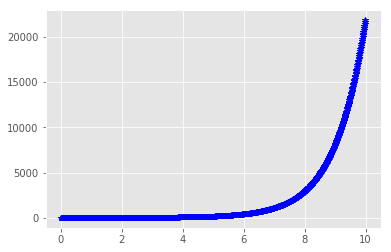

In [288]:
x_in = np.concatenate([np.arange(0,5,0.01), np.arange(5,10,0.01)])
#x_out = np.sin(2*x_in) + np.random.rand(len(x_in))*1
x_out = np.exp(x_in) + np.random.rand(len(x_in))*1

x = np.vstack([x_in, x_out]).T
plt.plot(x[:,0],x[:,1],'*b',zorder=1)

In [289]:
gmm = GMM(n_comp=10, D=2,K=30,weight_concentration=1)

In [290]:
gmm.fit(x,num_iter = 30,restart=True)

Iteration 0
Calculating ro
0.134631872177
Calculating Sk
0.386051893234
Iteration 1
Calculating ro
0.137753009796
Calculating Sk
0.385421991348
Iteration 2
Calculating ro
0.136905908585
Calculating Sk
0.364139080048
Iteration 3
Calculating ro
0.140323162079
Calculating Sk
0.358731985092
Iteration 4
Calculating ro
0.137444972992
Calculating Sk
0.361738920212
Iteration 5
Calculating ro
0.140655040741
Calculating Sk
0.365159034729
Iteration 6
Calculating ro
0.137242078781
Calculating Sk
0.361630916595
Iteration 7
Calculating ro
0.137637138367
Calculating Sk
0.361345052719
Iteration 8
Calculating ro
0.139023065567
Calculating Sk
0.353211164474
Iteration 9
Calculating ro
0.134896039963
Calculating Sk
0.356995105743
Iteration 10
Calculating ro
0.137761116028
Calculating Sk
0.354965209961
Iteration 11
Calculating ro
0.164566040039
Calculating Sk
0.421649932861
Iteration 12
Calculating ro
0.153979063034
Calculating Sk
0.384872198105
Iteration 13
Calculating ro
0.137744188309
Calculating Sk
0.3

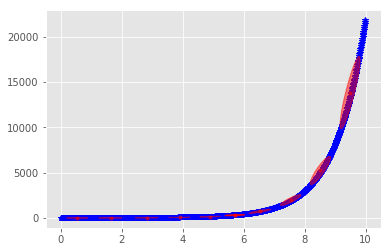

In [291]:
means, covs = filter_gaussian(gmm.mu, gmm.sigma, gmm.weights,threshold=0.01)
plot_gmm(means,covs)
plt.plot(x[:,0],x[:,1],'*b',zorder=1)
plt.show()

In [292]:
gmr = BGMR(gmm, 1, 1)
x_i = np.array([0.3])
print gmr.predict(x_i)

(array([1.8385]), array([[0.4733]]))


In [293]:
y_pred = []
y_cov = []
x_test = np.arange(-3,11,0.05)
for x_i in x_test:
    m, cov = (gmr.predict(np.array([x_i])))
    y_pred.append(m)
    y_cov.append(cov)
       
y_pred = np.array(y_pred)
y_cov = np.array(y_cov)

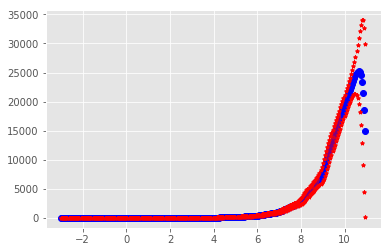

In [294]:
plt.plot(x_test, y_pred,'ob')
plt.plot(x_test, y_pred[:,0]+np.sqrt(y_cov[:,0,0]),'*r',markersize=4)
plt.plot(x_test,  y_pred[:,0]- np.sqrt(y_cov[:,0,0]),'*r',markersize=4)  
plot_gmm(means,covs)
plt.show()

### Project 

In [10]:
from scipy.io import loadmat
data_train = loadmat('data/sarcos_inv.mat')['sarcos_inv'][:,:22]
data_test = loadmat('data/sarcos_inv_test.mat')['sarcos_inv_test'][:,:22]

data_train.shape

x = data_train

D = x.shape[1]
K = 100
N = x.shape[0]

### subsample data

In [11]:
indexes = np.arange(0, len(data_train),1)
np.random.shuffle(indexes)
indexes = indexes[0:2000]
data_train = data_train[indexes]

In [12]:
gmm = GMM(K=50, D=22,weight_concentration=100)

In [13]:
gmm.fit(data_train,num_iter=30)

Iteration 0
Calculating ro
1.95501589775
Calculating Sk
3.99772286415
Iteration 1
Calculating ro
1.91687703133
Calculating Sk
4.03564405441
Iteration 2
Calculating ro
1.91852998734
Calculating Sk
4.08707094193
Iteration 3
Calculating ro
1.96715593338
Calculating Sk
4.15536999702
Iteration 4
Calculating ro
1.96707296371
Calculating Sk
4.10540795326
Iteration 5
Calculating ro
1.94834208488
Calculating Sk
4.08126688004
Iteration 6
Calculating ro
1.92033100128
Calculating Sk
4.10485696793
Iteration 7
Calculating ro
1.95256900787
Calculating Sk
4.11023497581
Iteration 8
Calculating ro
1.93431591988
Calculating Sk
4.06503796577
Iteration 9
Calculating ro
1.94750785828
Calculating Sk
4.08113980293
Iteration 10
Calculating ro
1.94052100182
Calculating Sk
4.03502011299
Iteration 11
Calculating ro
1.93701505661
Calculating Sk
4.10797190666
Iteration 12
Calculating ro
1.94763016701
Calculating Sk
4.11833500862
Iteration 13
Calculating ro
1.95716309547
Calculating Sk
4.0108089447
Iteration 14
Calc

In [14]:
gmr = GMR(gmm, n_in=21,n_out=1)

x = data_test[1,0:21]
gmr.predict(x)

In [15]:
x = data_test[1,0:21]
gmr.predict(x)

(array([11.771]), array([[39.8105]]))

In [16]:
pred = []
val = []
for i in range(data_test.shape[0]):
    print i
    pred.append(gmr.predict(data_test[i,0:21])[0])
    val.append(data_test[i,21])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


In [17]:
pred = np.array(pred).flatten()
val = np.array(val).flatten()

In [20]:
var = np.var(data_train[:,21])

In [21]:
(mean_squared_error(pred,val))/var

0.07001214965710482

### Using polynomial input

In [ ]:
x_train = data_train[:,0:21]
y_train = data_train[:,21:22]

x_test = data_test[:,0:21]
y_test = data_test[:,21:22]

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

data_train_poly = np.hstack([x_train_poly, y_train])
data_test_poly = np.hstack([x_test_poly, y_test])


In [12]:
gmm = GMM(K=50, D=data_train.shape[1],weight_concentration=100)

In [ ]:
gmm.fit(data_train_poly,num_iter=30)

In [14]:
gmr = GMR(gmm, n_in=x_train_poly.shape[1],n_out=1)
x = data_test_poly[2,:-1]
gmr.predict(x)

In [ ]:
pred = []
val = []
for i in range(data_test_poly.shape[0]):
    print i
    pred.append(gmr.predict(data_test_poly[i,:-1])[0])
    val.append(data_test_poly[i,-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


In [ ]:
pred = np.array(pred).flatten()
val = np.array(val).flatten()

In [509]:
var = np.var(data_train[:,21])

In [ ]:
(mean_squared_error(pred,val))/var